<a href="https://colab.research.google.com/github/avcioguzhan/ty-ds-case/blob/main/TY_Case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from datetime import date
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, scale
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
import math
from scipy import stats
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from matplotlib.pyplot import figure








Data Collection/Read

In [ ]:
df_basket=pd.read_csv('/content/drive/MyDrive/ds_2022/ds/df_basket.csv', parse_dates= ["partition_date"])
df_demo=pd.read_csv('/content/drive/MyDrive/ds_2022/ds/df_demo.csv')
df_fav=pd.read_csv('/content/drive/MyDrive/ds_2022/ds/df_fav.csv', parse_dates= ["partition_date"])
df_product=pd.read_csv("/content/drive/MyDrive/ds_2022/ds/df_product.csv")
df_search_term=pd.read_csv("/content/drive/MyDrive/ds_2022/ds/df_search_term.csv", parse_dates= ["partition_date"])
df_target_train=pd.read_csv('/content/drive/MyDrive/ds_2022/ds/df_target_train.csv')
df_test=pd.read_csv('/content/drive/MyDrive/ds_2022/ds/df_test.csv')
df_trx=pd.read_csv('/content/drive/MyDrive/ds_2022/ds/df_trx.csv', parse_dates= ["orderdate"])
df_visit=pd.read_csv('/content/drive/MyDrive/ds_2022/ds/df_visit.csv', parse_dates= ["partition_date"])

Unification of user and current bu group name

In [ ]:
df_userid_unique = df_target_train[['userid']].drop_duplicates().dropna()
df_bugroup_unique = df_target_train[['currentbugroupname']].drop_duplicates().dropna()

Creating Train Data

In [ ]:
#Cross merge between userid and bugroupname
df_train_data = df_userid_unique.merge(df_bugroup_unique, how = "cross")
df_train_data.shape

(244824, 2)

In [ ]:
#Adding order information to the selling lines in our train data
df_target_train["is_ordered"] = int(1)
df_target_train

,userid,currentbugroupname,is_ordered
0,28704634,GM,1
1,13506108,Ev,1
2,5893128,NaN,1
3,15209082,Mobilya,1
4,1109976,Kozmetik,1
...,...,...,...
27081,12568514,Ayakkabı & Çanta,1
27082,22288826,GM,1
27083,11887176,Private Label,1
27084,11887176,Ayakkabı & Çanta,1


In [ ]:
#Getting the order information from target train data to train data I created with cross merge with left merge
df_train_data_2 = df_train_data.merge(df_target_train, on=("userid", "currentbugroupname"), how= "left")

In [ ]:
#Completing the y label by making zero sales lines at the end of the left merge
df_train_data_2["is_ordered"]=df_train_data_2["is_ordered"].fillna(0)
df_train_data_2.shape
df_train_data_2.head()

,userid,currentbugroupname,is_ordered
0,28704634,GM,1.0
1,28704634,Ev,0.0
2,28704634,Mobilya,0.0
3,28704634,Kozmetik,0.0
4,28704634,Aksesuar & Saat & Gözlük,0.0


In [ ]:
#adding current group name data to properties using merge
df_trx_bu=df_trx.merge(df_product, on="contentid", suffixes=('trx','pr'), how= "left")
df_visit_bu=df_visit.merge(df_product, on="contentid", suffixes=('trx','pr'), how= "left")
df_basket_bu=df_basket.merge(df_product, on="contentid", suffixes=('trx','pr'), how= "left")
df_fav_bu=df_fav.merge(df_product, on="contentid", suffixes=('trx','pr'), how= "left")

In [ ]:
#checking isna
df_trx_bu[df_trx_bu["currentbugroupname"].isna()]

,userid,contentid,orderdate,quantity,price,currentbugroupname,brandid,gender,age,title,categoryname
5,29379994,55117154.0,2020-10-31 03:00:00,1,199.98,NaN,NaN,NaN,NaN,NaN,NaN
14,29379994,37035640.0,2020-10-31 03:00:00,1,59.99,NaN,NaN,NaN,NaN,NaN,NaN
16,11921448,47928255.0,2020-10-31 03:00:00,1,9.90,NaN,NaN,NaN,NaN,NaN,NaN
23,1936774,52514555.0,2020-11-01 03:00:00,1,29.97,NaN,NaN,NaN,NaN,NaN,NaN
29,13551132,3632536.0,2020-10-31 10:00:00,1,139.99,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
381529,2239524,44596422.0,2020-10-01 23:00:00,1,35.99,NaN,NaN,NaN,NaN,NaN,NaN
381530,2239524,34415865.0,2020-10-01 23:00:00,1,80.97,NaN,NaN,NaN,NaN,NaN,NaN
381532,12185110,44745787.0,2020-10-01 23:00:00,1,29.99,NaN,NaN,NaN,NaN,NaN,NaN
381533,10371438,4593533.0,2020-10-01 23:00:00,1,139.90,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_product[df_product["contentid"]==47928255.0]

,contentid,currentbugroupname,brandid,gender,age,title,categoryname


In [ ]:
#checking isna
df_visit_bu.isna().sum()

userid                      0
contentid                 302
partition_date              0
productdetailcount          0
currentbugroupname    3810107
brandid               3810107
gender                4847220
age                   5126087
title                 3812214
categoryname          3810107
dtype: int64

Finding= We recognize the missing data due to many content id dont match between product to others(trx,visit etc.)

Feature Extraction

In [ ]:
#added order data because each row represents an order
df_trx_bu["order"]=int(1)

In [ ]:
#added revenue
df_trx_bu["revenue"]=df_trx_bu["quantity"]*df_trx_bu["price"]


Creating **different time intervals**
*I divided my features according to different time intervals. I made sure they didn't cross each other.*

In [ ]:
#Calculate max date
print(df_trx_bu["orderdate"].max())
print(df_visit_bu["partition_date"].max())
print(df_fav_bu["partition_date"].max())
print(df_basket_bu["partition_date"].max())
print(df_search_term["partition_date"].max())


2020-11-01 03:00:00
2020-10-31 03:00:00
2020-10-31 03:00:00
2020-10-31 03:00:00
2020-10-31 00:00:00


**I checked if there is a shift in the trx data over the raw data, I did not discover a shift.**

In [ ]:
#trx time intervals
#Since the last day of trx data is 1 day longer than the others, I divided it into 5 different time zones.
df_trx_L0D = df_trx_bu[df_trx_bu["orderdate"]>"2020-10-31 03:00:00"].sort_values(by="orderdate", ascending = False)
df_trx_L1D = df_trx_bu[(df_trx_bu["orderdate"]<="2020-10-31 03:00:00") & (df_trx_bu["orderdate"]>"2020-10-30 03:00:00")].sort_values(by="orderdate", ascending = False)
df_trx_L1_3D = df_trx_bu[(df_trx_bu["orderdate"]<="2020-10-30 03:00:00") & (df_trx_bu["orderdate"]>"2020-10-28 03:00:00")].sort_values(by="orderdate", ascending = False)
df_trx_L3_7D = df_trx_bu[(df_trx_bu["orderdate"]<="2020-10-28 03:00:00") & (df_trx_bu["orderdate"]>"2020-10-24 03:00:00")].sort_values(by="orderdate", ascending = False)
df_trx_L7_14D = df_trx_bu[(df_trx_bu["orderdate"]<="2020-10-24 03:00:00") & (df_trx_bu["orderdate"]>"2020-10-17 03:00:00")].sort_values(by="orderdate", ascending = False)


In [ ]:
#visit time intervals
df_visit_L1D = df_visit_bu[df_visit_bu["partition_date"]>"2020-10-30 03:00:00"].sort_values(by="partition_date", ascending = False)
df_visit_L1_3D = df_visit_bu[(df_visit_bu["partition_date"]<="2020-10-30 03:00:00") & (df_visit_bu["partition_date"]>"2020-10-28 03:00:00")].sort_values(by="partition_date", ascending = False)
df_visit_L3_7D = df_visit_bu[(df_visit_bu["partition_date"]<="2020-10-28 03:00:00") & (df_visit_bu["partition_date"]>"2020-10-24 03:00:00")].sort_values(by="partition_date", ascending = False)
df_visit_L7_14D = df_visit_bu[(df_visit_bu["partition_date"]<="2020-10-24 03:00:00") & (df_visit_bu["partition_date"]>"2020-10-17 03:00:00")].sort_values(by="partition_date", ascending = False)

In [ ]:
#fav time intervals
df_fav_L1D = df_fav_bu[df_fav_bu["partition_date"]>"2020-10-30 03:00:00"].sort_values(by="partition_date", ascending = False)
df_fav_L1_3D = df_fav_bu[(df_fav_bu["partition_date"]<="2020-10-30 03:00:00") & (df_fav_bu["partition_date"]>"2020-10-28 03:00:00")].sort_values(by="partition_date", ascending = False)
df_fav_L3_7D = df_fav_bu[(df_fav_bu["partition_date"]<="2020-10-28 03:00:00") & (df_fav_bu["partition_date"]>"2020-10-24 03:00:00")].sort_values(by="partition_date", ascending = False)
df_fav_L7_14D = df_fav_bu[(df_fav_bu["partition_date"]<="2020-10-24 03:00:00") & (df_fav_bu["partition_date"]>"2020-10-17 03:00:00")].sort_values(by="partition_date", ascending = False)

In [ ]:
#basket time intervals
df_basket_L1D = df_basket_bu[df_basket_bu["partition_date"]>"2020-10-30 03:00:00"].sort_values(by="partition_date", ascending = False)
df_basket_L1_3D = df_basket_bu[(df_basket_bu["partition_date"]<="2020-10-30 03:00:00") & (df_basket_bu["partition_date"]>"2020-10-28 03:00:00")].sort_values(by="partition_date", ascending = False)
df_basket_L3_7D = df_basket_bu[(df_basket_bu["partition_date"]<="2020-10-28 03:00:00") & (df_basket_bu["partition_date"]>"2020-10-24 03:00:00")].sort_values(by="partition_date", ascending = False)
df_basket_L7_14D = df_basket_bu[(df_basket_bu["partition_date"]<="2020-10-24 03:00:00") & (df_basket_bu["partition_date"]>"2020-10-17 03:00:00")].sort_values(by="partition_date", ascending = False)

In [ ]:
#addsearchcount
df_search_term["search_count"]=1.0

In [ ]:
#search time intervals
df_search_L1D = df_search_term[df_search_term["partition_date"]>"2020-10-30 03:00:00"].sort_values(by="partition_date", ascending = False)
df_search_L1_3D = df_search_term[(df_search_term["partition_date"]<="2020-10-30 03:00:00") & (df_search_term["partition_date"]>"2020-10-28 03:00:00")].sort_values(by="partition_date", ascending = False)
df_search_L3_7D = df_search_term[(df_search_term["partition_date"]<="2020-10-28 03:00:00") & (df_search_term["partition_date"]>"2020-10-24 03:00:00")].sort_values(by="partition_date", ascending = False)
df_search_L7_14D = df_search_term[(df_search_term["partition_date"]<="2020-10-24 03:00:00") & (df_search_term["partition_date"]>"2020-10-17 03:00:00")].sort_values(by="partition_date", ascending = False)

Group by user id and current bu group name

In [ ]:
#trxgroup
trx_L0D_gby_userid_bu = df_trx_L0D.groupby(by= ["userid","currentbugroupname"])["quantity","revenue", "order"].sum().reset_index()
trx_L1D_gby_userid_bu = df_trx_L1D.groupby(by= ["userid","currentbugroupname"])["quantity","revenue", "order"].sum().reset_index()
trx_L1_3D_gby_userid_bu = df_trx_L1_3D.groupby(by= ["userid","currentbugroupname"])["quantity","revenue", "order"].sum().reset_index()
trx_L3_7D_gby_userid_bu = df_trx_L3_7D.groupby(by= ["userid","currentbugroupname"])["quantity","revenue", "order"].sum().reset_index()
trx_L7_14D_gby_userid_bu = df_trx_L7_14D.groupby(by= ["userid","currentbugroupname"])["quantity","revenue", "order"].sum().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (impli

In [ ]:
#visitgroup
visit_L1D_gby_userid_bu = df_visit_L1D.groupby(by= ["userid","currentbugroupname"])["productdetailcount"].sum().reset_index()
visit_L1_3D_gby_userid_bu = df_visit_L1_3D.groupby(by= ["userid","currentbugroupname"])["productdetailcount"].sum().reset_index()
visit_L3_7D_gby_userid_bu = df_visit_L3_7D.groupby(by= ["userid","currentbugroupname"])["productdetailcount"].sum().reset_index()
visit_L7_14D_gby_userid_bu = df_visit_L7_14D.groupby(by= ["userid","currentbugroupname"])["productdetailcount"].sum().reset_index()

In [ ]:
#favgroup
fav_L1D_gby_userid_bu = df_fav_L1D.groupby(by= ["userid","currentbugroupname"])["fav_count"].sum().reset_index()
fav_L1_3D_gby_userid_bu = df_fav_L1_3D.groupby(by= ["userid","currentbugroupname"])["fav_count"].sum().reset_index()
fav_L3_7D_gby_userid_bu = df_fav_L3_7D.groupby(by= ["userid","currentbugroupname"])["fav_count"].sum().reset_index()
fav_L7_14D_gby_userid_bu = df_fav_L7_14D.groupby(by= ["userid","currentbugroupname"])["fav_count"].sum().reset_index()

In [ ]:
#basketgroup
basket_L1D_gby_userid_bu = df_basket_L1D.groupby(by= ["userid","currentbugroupname"])["addtobasket_count"].sum().reset_index()
basket_L1_3D_gby_userid_bu = df_basket_L1_3D.groupby(by= ["userid","currentbugroupname"])["addtobasket_count"].sum().reset_index()
basket_L3_7D_gby_userid_bu = df_basket_L3_7D.groupby(by= ["userid","currentbugroupname"])["addtobasket_count"].sum().reset_index()
basket_L7_14D_gby_userid_bu = df_basket_L7_14D.groupby(by= ["userid","currentbugroupname"])["addtobasket_count"].sum().reset_index()

Group by onlyuser id,  
I aim to gain the information by grouping **only the user id.**, because i have many missing data due to the content id match in the product data source

In [ ]:
#trxgroup
trx_L0D_gby_userid = df_trx_L0D.groupby(by= ["userid"])["quantity","revenue", "order"].sum().reset_index()
trx_L1D_gby_userid = df_trx_L1D.groupby(by= ["userid"])["quantity","revenue", "order"].sum().reset_index()
trx_L1_3D_gby_userid = df_trx_L1_3D.groupby(by= ["userid"])["quantity","revenue", "order"].sum().reset_index()
trx_L3_7D_gby_userid = df_trx_L3_7D.groupby(by= ["userid"])["quantity","revenue", "order"].sum().reset_index()
trx_L7_14D_gby_userid = df_trx_L7_14D.groupby(by= ["userid"])["quantity","revenue", "order"].sum().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (impli

In [ ]:
#visitgroup
visit_L1D_gby_userid = df_visit_L1D.groupby(by= ["userid"])["productdetailcount"].sum().reset_index()
visit_L1_3D_gby_userid = df_visit_L1_3D.groupby(by= ["userid"])["productdetailcount"].sum().reset_index()
visit_L3_7D_gby_userid = df_visit_L3_7D.groupby(by= ["userid"])["productdetailcount"].sum().reset_index()
visit_L7_14D_gby_userid = df_visit_L7_14D.groupby(by= ["userid"])["productdetailcount"].sum().reset_index()

In [ ]:
#favgroup
fav_L1D_gby_userid = df_fav_L1D.groupby(by= ["userid"])["fav_count"].sum().reset_index()
fav_L1_3D_gby_userid = df_fav_L1_3D.groupby(by= ["userid"])["fav_count"].sum().reset_index()
fav_L3_7D_gby_userid = df_fav_L3_7D.groupby(by= ["userid"])["fav_count"].sum().reset_index()
fav_L7_14D_gby_userid = df_fav_L7_14D.groupby(by= ["userid"])["fav_count"].sum().reset_index()

In [ ]:
#basketgroup
basket_L1D_gby_userid = df_basket_L1D.groupby(by= ["userid"])["addtobasket_count"].sum().reset_index()
basket_L1_3D_gby_userid = df_basket_L1_3D.groupby(by= ["userid"])["addtobasket_count"].sum().reset_index()
basket_L3_7D_gby_userid = df_basket_L3_7D.groupby(by= ["userid",])["addtobasket_count"].sum().reset_index()
basket_L7_14D_gby_userid = df_basket_L7_14D.groupby(by= ["userid"])["addtobasket_count"].sum().reset_index()

In [ ]:
#searchgroup
search_L1D_gby_userid = df_search_L1D.groupby(by= ["userid"])["search_count"].sum().reset_index()
search_L1_3D_gby_userid = df_search_L1_3D.groupby(by= ["userid"])["search_count"].sum().reset_index()
search_L3_7D_gby_userid = df_search_L3_7D.groupby(by= ["userid",])["search_count"].sum().reset_index()
search_L7_14D_gby_userid = df_search_L7_14D.groupby(by= ["userid"])["search_count"].sum().reset_index()


Final Train Data

In [ ]:
df_train_data_3 = df_train_data_2.merge(trx_L1D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("train", "")) \
.merge(trx_L1D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1D_user_group", "_L1D_user")) \
.merge(trx_L1_3D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("", "_L1_3D_user_group")) \
.merge(trx_L3_7D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L1_3D_user_group", "_L3_7D_user_group")) \
.merge(trx_L7_14D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L3_7D_user_group", "")) \
.merge(trx_L0D_gby_userid_bu, on= ["userid","currentbugroupname"], how="left", suffixes = ("_L7_14D_user_group", "_LOD_user_group")) \
.merge(visit_L1D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L0D_user_group", "_L1D_user_group")) \
.merge(visit_L1_3D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L1D_user_group", "_L1_3D_user_group")) \
.merge(visit_L3_7D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L1_3D_user_group", "_L3_7D_user_group")) \
.merge(visit_L7_14D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L3_7D_user_group", "_L7_14D_user_group")) \
.merge(fav_L1D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L7_14D_user_group", "_L1D_user_group")) \
.merge(fav_L1_3D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L1D_user_group", "_L1_3D_user_group")) \
.merge(fav_L3_7D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L1_3D_user_group", "_L3_7D_user_group")) \
.merge(fav_L7_14D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L3_7D_user_group", "_L7_14D_user_group")) \
.merge(basket_L1D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L7_14Dv", "_L1D_user_group")) \
.merge(basket_L1_3D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L1D_user_group", "_L1_3D_user_group")) \
.merge(basket_L3_7D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L1_3D_user_group", "_L3_7D_user_group")) \
.merge(basket_L7_14D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L3_7D_user_group", "_L7_14D_user_group")) \
.merge(trx_L1_3D_gby_userid, on = ["userid"], how="left", suffixes = ("_L7_14D_user_group", "_L1_3D_user")) \
.merge(trx_L3_7D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1_3D_user", "_L3_7D_user")) \
.merge(trx_L7_14D_gby_userid, on = ["userid"], how="left", suffixes = ("_L3_7D_user", "")) \
.merge(trx_L0D_gby_userid, on= ["userid"], how="left", suffixes = ("_L7_14D_user", "_LOD_user")) \
.merge(visit_L1D_gby_userid, on = ["userid"], how="left", suffixes = ("_L0D_user", "_L1D_user")) \
.merge(visit_L1_3D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1D_user", "_L1_3D_user")) \
.merge(visit_L3_7D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1_3D_user", "_L3_7D_user")) \
.merge(visit_L7_14D_gby_userid, on = ["userid"], how="left", suffixes = ("_L3_7D_user", "_L7_14D_user")) \
.merge(fav_L1D_gby_userid, on = ["userid"], how="left", suffixes = ("_L7_14D_user", "_L1D_user")) \
.merge(fav_L1_3D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1D_user", "_L1_3D_user")) \
.merge(fav_L3_7D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1_3D_user", "_L3_7D_user")) \
.merge(fav_L7_14D_gby_userid, on = ["userid"], how="left", suffixes = ("_L3_7D_user", "_L7_14D_user")) \
.merge(basket_L1D_gby_userid, on = ["userid"], how="left", suffixes = ("_L7_14D_user", "_L1D_user")) \
.merge(basket_L1_3D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1D_user", "_L1_3D_user")) \
.merge(basket_L3_7D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1_3D_user", "_L3_7D_user")) \
.merge(basket_L7_14D_gby_userid, on = ["userid"], how="left", suffixes = ("_L3_7D_user", "_L7_14D_user")) \
.merge(search_L1D_gby_userid, on = ["userid"], how="left", suffixes = ("_L7_14D_user", "_L1D_user")) \
.merge(search_L1_3D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1D_user", "_L1_3D_user")) \
.merge(search_L3_7D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1_3D_user", "_L3_7D_user")) \
.merge(search_L7_14D_gby_userid, on = ["userid"], how="left", suffixes = ("_L3_7D_user", "_L7_14D_user")) 


In [ ]:
#add demography data
df_train_final = df_train_data_3.merge(df_demo, on="userid", how= "left")
df_train_final.head()

,userid,currentbugroupname,is_ordered,quantity_L1D_user_group,revenue_L1D_user_group,order_L1D_user_group,quantity_L1D_user,revenue_L1D_user,order_L1D_user,quantity_L1_3D_user_group,...,addtobasket_count_L1_3D_user,addtobasket_count_L3_7D_user,addtobasket_count_L7_14D_user,search_count_L1D_user,search_count_L1_3D_user,search_count_L3_7D_user,search_count_L7_14D_user,gender,age,tenure
0,28704634,GM,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,2.0,2.0,3.0,Bay,22.0,10
1,28704634,Ev,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,2.0,2.0,3.0,Bay,22.0,10
2,28704634,Mobilya,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,2.0,2.0,3.0,Bay,22.0,10
3,28704634,Kozmetik,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,2.0,2.0,3.0,Bay,22.0,10
4,28704634,Aksesuar & Saat & Gözlük,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,2.0,2.0,3.0,Bay,22.0,10


In [ ]:
#check coloumns
df_train_final.columns

Index(['userid', 'currentbugroupname', 'is_ordered', 'quantity_L1D_user_group',
       'revenue_L1D_user_group', 'order_L1D_user_group', 'quantity_L1D_user',
       'revenue_L1D_user', 'order_L1D_user', 'quantity_L1_3D_user_group',
       'revenue_L1_3D_user_group', 'order_L1_3D_user_group',
       'quantity_L3_7D_user_group', 'revenue_L3_7D_user_group',
       'order_L3_7D_user_group', 'quantity_L7_14D_user_group',
       'revenue_L7_14D_user_group', 'order_L7_14D_user_group',
       'quantity_LOD_user_group', 'revenue_LOD_user_group',
       'order_LOD_user_group', 'productdetailcount_L1D_user_group',
       'productdetailcount_L1_3D_user_group',
       'productdetailcount_L3_7D_user_group',
       'productdetailcount_L7_14D_user_group', 'fav_count_L1D_user_group',
       'fav_count_L1_3D_user_group', 'fav_count_L3_7D_user_group',
       'fav_count_L7_14D_user_group', 'addtobasket_count_L1D_user_group',
       'addtobasket_count_L1_3D_user_group',
       'addtobasket_count_L3_7D_user

Data Analysis

In [ ]:
df_train_final.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,244824.0,1.925991e+07,1.129404e+07,2086.00,11072978.00,17589376.00,27333908.0,44625651.0
is_ordered,244824.0,1.010277e-01,3.013660e-01,0.00,0.00,0.00,0.0,1.0
quantity_L1D_user_group,1991.0,2.195881e+00,3.209878e+00,1.00,1.00,1.00,2.0,65.0
revenue_L1D_user_group,1991.0,2.362443e+02,1.109199e+03,0.96,49.45,89.98,178.1,34960.0
order_L1D_user_group,1991.0,1.914616e+00,2.532153e+00,1.00,1.00,1.00,2.0,44.0
...,...,...,...,...,...,...,...,...
search_count_L1_3D_user,110364.0,4.469610e+00,5.381854e+00,1.00,1.00,3.00,5.0,147.0
search_count_L3_7D_user,144516.0,6.645105e+00,8.649808e+00,1.00,2.00,4.00,8.0,156.0
search_count_L7_14D_user,171588.0,9.822295e+00,1.351438e+01,1.00,2.00,5.00,12.0,397.0
age,151008.0,2.186062e+02,5.517107e+02,-48.00,27.00,35.00,120.0,2019.0


Findings: In many features, there are values outside of normal in the upward max values.
When we examine the age data at the first stage, we see that more than 25% of them are 120 years old. 1900 may have been entered as the year. If I delete outliers of age value, I will lose more than 25% of the data. That's why I'm dropping the age property.

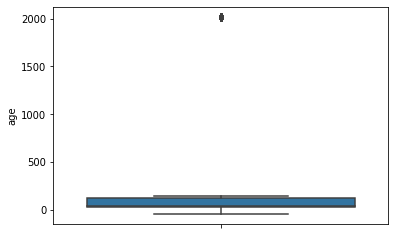

In [ ]:
#ageboxplot
sns.boxplot( y="age", data=df_train_final)

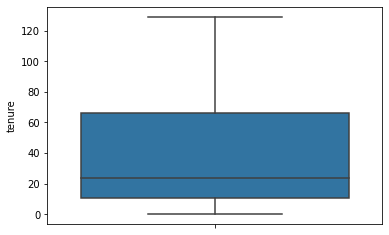

In [ ]:
#tenureboxplot
sns.boxplot( y="tenure", data=df_train_final)

In [ ]:
#tenuremaxvalues
df_train_final["tenure"].sort_values(ascending= False)

101932    129
101928    129
101930    129
101931    129
101933    129
         ... 
148227      0
148228      0
148229      0
148230      0
231221      0
Name: tenure, Length: 244824, dtype: int64

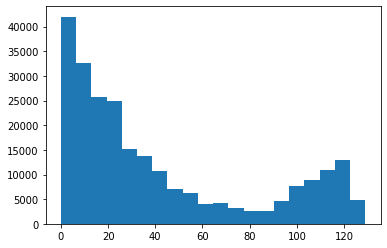

In [ ]:
#tenurehistogram
plt.hist(df_train_final["tenure"], bins=20)
plt.show()

Finding: When I examined the Tenure feature, I saw that there was a lot of incorrect data, so I dropped the feature.

In [ ]:
#dropping age and tenure
df_train_final2=df_train_final.drop(columns=['age', 'tenure'])


In [ ]:
#checkingcolumns
df_train_final.columns

Index(['userid', 'currentbugroupname', 'is_ordered', 'quantity_L1D_user_group',
       'revenue_L1D_user_group', 'order_L1D_user_group', 'quantity_L1D_user',
       'revenue_L1D_user', 'order_L1D_user', 'quantity_L1_3D_user_group',
       'revenue_L1_3D_user_group', 'order_L1_3D_user_group',
       'quantity_L3_7D_user_group', 'revenue_L3_7D_user_group',
       'order_L3_7D_user_group', 'quantity_L7_14D_user_group',
       'revenue_L7_14D_user_group', 'order_L7_14D_user_group',
       'quantity_LOD_user_group', 'revenue_LOD_user_group',
       'order_LOD_user_group', 'productdetailcount_L1D_user_group',
       'productdetailcount_L1_3D_user_group',
       'productdetailcount_L3_7D_user_group',
       'productdetailcount_L7_14D_user_group', 'fav_count_L1D_user_group',
       'fav_count_L1_3D_user_group', 'fav_count_L3_7D_user_group',
       'fav_count_L7_14D_user_group', 'addtobasket_count_L1D_user_group',
       'addtobasket_count_L1_3D_user_group',
       'addtobasket_count_L3_7D_user

In [ ]:
df_train_final2[["productdetailcount_L1D_user_group", "revenue_L1D_user_group"]].isna().value_counts()

productdetailcount_L1D_user_group  revenue_L1D_user_group
True                               True                      217283
False                              True                       25550
True                               False                       1011
False                              False                        980
dtype: int64

Finding: There are 1011 samples that are for sale but do not come to the product detail page at the same time. It may have gone directly from the favorite page to the cart.

In [ ]:
df_train_final2[["revenue_L1D_user_group", "addtobasket_count_L1D_user_group"]].isna().value_counts()

revenue_L1D_user_group  addtobasket_count_L1D_user_group
True                    True                                242806
False                   True                                  1991
True                    False                                   27
dtype: int64

Finding: There are 1991 examples with the number of additions to the basket in the same time period and the income greater than 0. This means that most items are purchased at least one day after adding to the cart.

Based on the **two different findings** above, I stopped adding cr and trx/basket data containing the same time period, because most of them would be null. In phase 2 or 3, I plan to identify different time periods and add them to the model.

In [ ]:
#Add cr%
#df_train_final["cr_L1D"]=df_train_final["order_L1D"]/df_train_final["productdetailcount_L1D"]
#df_train_final["cr_L1_3D"]=df_train_final["order_L1_3D"]/df_train_final["productdetailcount_L1_3D"]
#df_train_final["cr_L3_7D"]=df_train_final["order_L3_7D"]/df_train_final["productdetailcount_L3_7D"]
#df_train_final["cr_L7_14D"]=df_train_final["order_L7_14D"]/df_train_final["productdetailcount_L7_14D"]

In [ ]:
#Add_trx/basket
#df_train_final["trx/a2b_L1D"]=df_train_final["order_L1D"]/df_train_final["addtobasket_count_L1D"]
#df_train_final["trx/a2b_L1_3D"]=df_train_final["order_L1_3D"]/df_train_final["addtobasket_count_L1_3D"]
#df_train_final["trx/a2b_L3_7D"]=df_train_final["order_L3_7D"]/df_train_final["addtobasket_count_L3_7D"]
#df_train_final["trx/a2b_L7_14D"]=df_train_final["order_L7_14D"]/df_train_final["addtobasket_count_L7_14D"]

**Missing** data analysis

In [ ]:
#gendervaluecounts
df_train_final2["gender"].value_counts()

Bayan               186696
Bay                  56784
UNKNOWN               1296
kvkktalepsilindi        48
Name: gender, dtype: int64

In [ ]:
#drop"unkown" and "kvkktalepsilindi"
df_train_final2.drop(df_train_final2[df_train_final2["gender"] == "UNKNOWN"].index, inplace= True)
df_train_final2.drop(df_train_final2[df_train_final2["gender"] == "kvkktalepsilindi"].index, inplace= True)
df_train_final2["gender"].value_counts()


Bayan    186696
Bay       56784
Name: gender, dtype: int64

In [ ]:
#Encoder
gender_dummy = pd.get_dummies(df_train_final2["gender"], drop_first = True)
print(gender_dummy)

        Bayan
0           0
1           0
2           0
3           0
4           0
...       ...
244819      1
244820      1
244821      1
244822      1
244823      1

[243480 rows x 1 columns]


In [ ]:
#concatgender
df_train_final3 = pd.concat([df_train_final2, gender_dummy], axis=1)
df_train_final4 = df_train_final3.drop("gender", axis=1)
df_train_final4.columns


Index(['userid', 'currentbugroupname', 'is_ordered', 'quantity_L1D_user_group',
       'revenue_L1D_user_group', 'order_L1D_user_group', 'quantity_L1D_user',
       'revenue_L1D_user', 'order_L1D_user', 'quantity_L1_3D_user_group',
       'revenue_L1_3D_user_group', 'order_L1_3D_user_group',
       'quantity_L3_7D_user_group', 'revenue_L3_7D_user_group',
       'order_L3_7D_user_group', 'quantity_L7_14D_user_group',
       'revenue_L7_14D_user_group', 'order_L7_14D_user_group',
       'quantity_LOD_user_group', 'revenue_LOD_user_group',
       'order_LOD_user_group', 'productdetailcount_L1D_user_group',
       'productdetailcount_L1_3D_user_group',
       'productdetailcount_L3_7D_user_group',
       'productdetailcount_L7_14D_user_group', 'fav_count_L1D_user_group',
       'fav_count_L1_3D_user_group', 'fav_count_L3_7D_user_group',
       'fav_count_L7_14D_user_group', 'addtobasket_count_L1D_user_group',
       'addtobasket_count_L1_3D_user_group',
       'addtobasket_count_L3_7D_user

Check Missing Data

In [ ]:
#isna_count
df_train_final4.isna().sum().sort_values()

userid                                      0
is_ordered                                  0
Bayan                                       0
currentbugroupname                          0
productdetailcount_L7_14D_user          35436
                                        ...  
addtobasket_count_L1D_user             243180
addtobasket_count_L7_14D_user_group    243242
addtobasket_count_L3_7D_user_group     243355
addtobasket_count_L1_3D_user_group     243414
addtobasket_count_L1D_user_group       243454
Length: 62, dtype: int64

In [ ]:
#check shape and columns
print(df_train_final4.shape)
print(df_train_final4.columns)

(243480, 62)
Index(['userid', 'currentbugroupname', 'is_ordered', 'quantity_L1D_user_group',
       'revenue_L1D_user_group', 'order_L1D_user_group', 'quantity_L1D_user',
       'revenue_L1D_user', 'order_L1D_user', 'quantity_L1_3D_user_group',
       'revenue_L1_3D_user_group', 'order_L1_3D_user_group',
       'quantity_L3_7D_user_group', 'revenue_L3_7D_user_group',
       'order_L3_7D_user_group', 'quantity_L7_14D_user_group',
       'revenue_L7_14D_user_group', 'order_L7_14D_user_group',
       'quantity_LOD_user_group', 'revenue_LOD_user_group',
       'order_LOD_user_group', 'productdetailcount_L1D_user_group',
       'productdetailcount_L1_3D_user_group',
       'productdetailcount_L3_7D_user_group',
       'productdetailcount_L7_14D_user_group', 'fav_count_L1D_user_group',
       'fav_count_L1_3D_user_group', 'fav_count_L3_7D_user_group',
       'fav_count_L7_14D_user_group', 'addtobasket_count_L1D_user_group',
       'addtobasket_count_L1_3D_user_group',
       'addtobasket_cou

In [ ]:
#fillnatozero
df_train_final5 = df_train_final4[['userid', 'currentbugroupname', 'is_ordered', 'quantity_L1D_user_group',
       'revenue_L1D_user_group', 'order_L1D_user_group', 'quantity_L1D_user',
       'revenue_L1D_user', 'order_L1D_user', 'quantity_L1_3D_user_group',
       'revenue_L1_3D_user_group', 'order_L1_3D_user_group',
       'quantity_L3_7D_user_group', 'revenue_L3_7D_user_group',
       'order_L3_7D_user_group', 'quantity_L7_14D_user_group',
       'revenue_L7_14D_user_group', 'order_L7_14D_user_group',
       'quantity_LOD_user_group', 'revenue_LOD_user_group',
       'order_LOD_user_group', 'productdetailcount_L1D_user_group',
       'productdetailcount_L1_3D_user_group',
       'productdetailcount_L3_7D_user_group',
       'productdetailcount_L7_14D_user_group', 'fav_count_L1D_user_group',
       'fav_count_L1_3D_user_group', 'fav_count_L3_7D_user_group',
       'fav_count_L7_14D_user_group', 'addtobasket_count_L1D_user_group',
       'addtobasket_count_L1_3D_user_group',
       'addtobasket_count_L3_7D_user_group',
       'addtobasket_count_L7_14D_user_group', 'quantity_L1_3D_user',
       'revenue_L1_3D_user', 'order_L1_3D_user', 'quantity_L3_7D_user',
       'revenue_L3_7D_user', 'order_L3_7D_user', 'quantity_L7_14D_user',
       'revenue_L7_14D_user', 'order_L7_14D_user', 'quantity_LOD_user',
       'revenue_LOD_user', 'order_LOD_user', 'productdetailcount_L1D_user',
       'productdetailcount_L1_3D_user', 'productdetailcount_L3_7D_user',
       'productdetailcount_L7_14D_user', 'fav_count_L1D_user',
       'fav_count_L1_3D_user', 'fav_count_L3_7D_user', 'fav_count_L7_14D_user',
       'addtobasket_count_L1D_user', 'addtobasket_count_L1_3D_user',
       'addtobasket_count_L3_7D_user', 'addtobasket_count_L7_14D_user',
       'search_count_L1D_user', 'search_count_L1_3D_user',
       'search_count_L3_7D_user', 'search_count_L7_14D_user', 'Bayan']].fillna(0)

In [ ]:
#checknaagain
print(df_train_final5.isna().sum().sort_values())
print(df_train_final5.shape)
print(df_train_final5.columns)

userid                         0
quantity_L1_3D_user            0
revenue_L1_3D_user             0
order_L1_3D_user               0
quantity_L3_7D_user            0
                              ..
fav_count_L1_3D_user_group     0
fav_count_L3_7D_user_group     0
fav_count_L7_14D_user_group    0
quantity_L7_14D_user_group     0
Bayan                          0
Length: 62, dtype: int64
(243480, 62)
Index(['userid', 'currentbugroupname', 'is_ordered', 'quantity_L1D_user_group',
       'revenue_L1D_user_group', 'order_L1D_user_group', 'quantity_L1D_user',
       'revenue_L1D_user', 'order_L1D_user', 'quantity_L1_3D_user_group',
       'revenue_L1_3D_user_group', 'order_L1_3D_user_group',
       'quantity_L3_7D_user_group', 'revenue_L3_7D_user_group',
       'order_L3_7D_user_group', 'quantity_L7_14D_user_group',
       'revenue_L7_14D_user_group', 'order_L7_14D_user_group',
       'quantity_LOD_user_group', 'revenue_LOD_user_group',
       'order_LOD_user_group', 'productdetailcount_L1D_u

Check Class Imbalance

In [ ]:
#labelvaluecounts
df_train_final5["is_ordered"].value_counts()

0.0    218887
1.0     24593
Name: is_ordered, dtype: int64

In [ ]:
#filtering_ylabel
df_train_final5_isordered_1= df_train_final5[df_train_final5["is_ordered"]==1.0]
df_train_final5_isordered_0= df_train_final5[df_train_final5["is_ordered"]==0.0]


In [ ]:
#checkingshape
print(df_train_final5_isordered_1.shape)
print(df_train_final5_isordered_0.shape)

(24593, 62)
(218887, 62)


handle with cross imbalance

In [ ]:
#downsize the sample
df_train_final5_isordered_0_sample = df_train_final5_isordered_0.sample(n=24593)


After handle with cross imbalance


In [ ]:
#after downsize the y label
df_train_final6 = pd.concat([df_train_final5_isordered_0_sample, df_train_final5_isordered_1], axis = 0)

In [ ]:
#check shape
print(df_train_final6["is_ordered"].value_counts())
print(df_train_final6.columns)


0.0    24593
1.0    24593
Name: is_ordered, dtype: int64
Index(['userid', 'currentbugroupname', 'is_ordered', 'quantity_L1D_user_group',
       'revenue_L1D_user_group', 'order_L1D_user_group', 'quantity_L1D_user',
       'revenue_L1D_user', 'order_L1D_user', 'quantity_L1_3D_user_group',
       'revenue_L1_3D_user_group', 'order_L1_3D_user_group',
       'quantity_L3_7D_user_group', 'revenue_L3_7D_user_group',
       'order_L3_7D_user_group', 'quantity_L7_14D_user_group',
       'revenue_L7_14D_user_group', 'order_L7_14D_user_group',
       'quantity_LOD_user_group', 'revenue_LOD_user_group',
       'order_LOD_user_group', 'productdetailcount_L1D_user_group',
       'productdetailcount_L1_3D_user_group',
       'productdetailcount_L3_7D_user_group',
       'productdetailcount_L7_14D_user_group', 'fav_count_L1D_user_group',
       'fav_count_L1_3D_user_group', 'fav_count_L3_7D_user_group',
       'fav_count_L7_14D_user_group', 'addtobasket_count_L1D_user_group',
       'addtobasket_coun

In [ ]:
df_train_final6.describe()

,userid,is_ordered,quantity_L1D_user_group,revenue_L1D_user_group,order_L1D_user_group,quantity_L1D_user,revenue_L1D_user,order_L1D_user,quantity_L1_3D_user_group,revenue_L1_3D_user_group,...,fav_count_L7_14D_user,addtobasket_count_L1D_user,addtobasket_count_L1_3D_user,addtobasket_count_L3_7D_user,addtobasket_count_L7_14D_user,search_count_L1D_user,search_count_L1_3D_user,search_count_L3_7D_user,search_count_L7_14D_user,Bayan
count,4.918600e+04,49186.000000,49186.000000,49186.000000,49186.000000,49186.000000,49186.000000,49186.000000,49186.000000,49186.000000,...,49186.000000,49186.000000,49186.000000,49186.000000,49186.000000,49186.000000,49186.000000,49186.000000,49186.000000,49186.000000
mean,1.890966e+07,0.500000,0.046578,5.118503,0.040255,0.417009,42.607280,0.368519,0.092384,8.039870,...,4.658195,0.003294,0.012402,0.013947,0.029358,1.325235,2.219270,4.301590,7.546802,0.776054
std,1.116547e+07,0.500005,0.663798,155.265415,0.551068,4.136513,597.525859,3.674773,1.010610,132.350662,...,20.159671,0.118225,0.380645,0.217485,0.393337,3.254500,4.605627,8.077426,13.521121,0.416890
min,2.086000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.088387e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.709946e+07,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000
75%,2.687560e+07,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,5.000000,9.000000,1.000000
max,4.462565e+07,1.000000,65.000000,27490.000000,44.000000,140.000000,40424.760000,130.000000,84.000000,13240.780000,...,963.000000,11.000000,26.000000,10.000000,24.000000,47.000000,147.000000,156.000000,397.000000,1.000000


Finding: When we examine the max points, we see that there are many upwards outliers. But every time I delete this data, I reduce the number of sales samples that I already have. That's why I move forward without interfering with the outliers.

Build a Logit Reg Model
Checking p-values to check feature importance

In [ ]:
# defining the dependent and independent variables
x_logit=df_train_final6[['quantity_L1D_user_group',
       'revenue_L1D_user_group', 'order_L1D_user_group', 'quantity_L1D_user',
       'revenue_L1D_user', 'order_L1D_user', 'quantity_L1_3D_user_group',
       'revenue_L1_3D_user_group', 'order_L1_3D_user_group',
       'quantity_L3_7D_user_group', 'revenue_L3_7D_user_group',
       'order_L3_7D_user_group', 'quantity_L7_14D_user_group',
       'revenue_L7_14D_user_group', 'order_L7_14D_user_group',
       'quantity_LOD_user_group', 'revenue_LOD_user_group',
       'order_LOD_user_group', 'productdetailcount_L1D_user_group',
       'productdetailcount_L1_3D_user_group',
       'productdetailcount_L3_7D_user_group',
       'productdetailcount_L7_14D_user_group', 'fav_count_L1D_user_group',
       'fav_count_L1_3D_user_group', 'fav_count_L3_7D_user_group',
       'fav_count_L7_14D_user_group', 'addtobasket_count_L1D_user_group',
       'addtobasket_count_L1_3D_user_group',
       'addtobasket_count_L3_7D_user_group',
       'addtobasket_count_L7_14D_user_group', 'quantity_L1_3D_user',
       'revenue_L1_3D_user', 'order_L1_3D_user', 'quantity_L3_7D_user',
       'revenue_L3_7D_user', 'order_L3_7D_user', 'quantity_L7_14D_user',
       'revenue_L7_14D_user', 'order_L7_14D_user', 'quantity_LOD_user',
       'revenue_LOD_user', 'order_LOD_user', 'productdetailcount_L1D_user',
       'productdetailcount_L1_3D_user', 'productdetailcount_L3_7D_user',
       'productdetailcount_L7_14D_user', 'fav_count_L1D_user',
       'fav_count_L1_3D_user', 'fav_count_L3_7D_user', 'fav_count_L7_14D_user',
       'addtobasket_count_L1D_user', 'addtobasket_count_L1_3D_user',
       'addtobasket_count_L3_7D_user', 'addtobasket_count_L7_14D_user',
       'search_count_L1D_user', 'search_count_L1_3D_user',
       'search_count_L3_7D_user', 'search_count_L7_14D_user', 'Bayan']]
y_logit=df_train_final6["is_ordered"]

In [ ]:
# building the model and fitting the data
log_reg = sm.Logit(y_logit, x_logit).fit()
# printing the summary table
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.631446
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:             is_ordered   No. Observations:                49186
Model:                          Logit   Df Residuals:                    49127
Method:                           MLE   Df Model:                           58
Date:                Wed, 24 Aug 2022   Pseudo R-squ.:                 0.08902
Time:                        19:03:30   Log-Likelihood:                -31058.
converged:                       True   LL-Null:                       -34093.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
quantity_L1D_user_group                  0.3102      0.1

Findings: After checking the p value with coef, the features I want to include in the logistic regression model are: 
***quantity_L1_3D_user_group
quantity_L3_7D_user_group
quantity_L7_14D_user_group
productdetailcount_L1D_user_group
productdetailcount_L1_3D_user_group
productdetailcount_L3_7D_user_group
productdetailcount_L7_14D_user_group
fav_count_L1_3D_user_group
fav_count_L3_7D_user_group
fav_count_L7_14D_user_group
addtobasket_count_L3_7D_user_group
order_L7_14D_user
Bayan***

Build a Logistic Regression Model

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.656942467981297
              precision    recall  f1-score   support

         0.0       0.60      0.90      0.72      4859
         1.0       0.81      0.42      0.55      4979

    accuracy                           0.66      9838
   macro avg       0.71      0.66      0.64      9838
weighted avg       0.71      0.66      0.64      9838



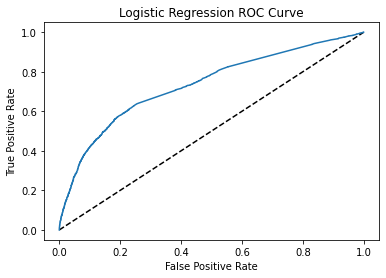

AUC Score: 0.733969314462996


In [ ]:
# defining the dependent and independent variables
x=df_train_final6[["quantity_L1_3D_user_group",
"quantity_L3_7D_user_group",
"quantity_L7_14D_user_group",
"productdetailcount_L1D_user_group",
"productdetailcount_L1_3D_user_group",
"productdetailcount_L3_7D_user_group",
"productdetailcount_L7_14D_user_group",
"fav_count_L1_3D_user_group",
"fav_count_L3_7D_user_group",
"fav_count_L7_14D_user_group",
"addtobasket_count_L3_7D_user_group",
"order_L7_14D_user",
"Bayan"]].values
y=df_train_final6["is_ordered"].values.reshape(-1,1)

#train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12)


#standart scale and model fit
steps = [("scaler", StandardScaler()), 
         ("logreg", LogisticRegression())]
pipeline = Pipeline(steps)


pipeline.fit(x_train, y_train)
y_pred_probs = pipeline.predict_proba(x_test)[:,1]
y_pred = pipeline.predict(x_test)


print("Accuracy: {}".format(pipeline.score(x_test, y_test)))
print(classification_report(y_test, y_pred))

#Roc_auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot([0, 1], [0, 1],'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()
print("AUC Score: {}".format(roc_auc_score(y_test, y_pred_probs)))


Feature Importance in Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


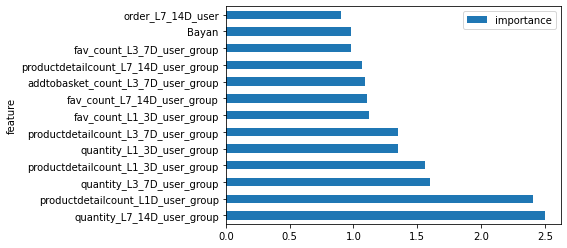

In [ ]:
#Scaling
x_scale= scale(x)
y_scale= scale(y)

#train test split
x_train, x_test, y_train, y_test = train_test_split(x_scale, y_scale, test_size=0.2, random_state=12)
              
model = LogisticRegression().fit(x_train, y_train)
w0 = model.intercept_[0]
w = model.coef_[0]
feature_names = df_train_final6[["quantity_L1_3D_user_group",
"quantity_L3_7D_user_group",
"quantity_L7_14D_user_group",
"productdetailcount_L1D_user_group",
"productdetailcount_L1_3D_user_group",
"productdetailcount_L3_7D_user_group",
"productdetailcount_L7_14D_user_group",
"fav_count_L1_3D_user_group",
"fav_count_L3_7D_user_group",
"fav_count_L7_14D_user_group",
"addtobasket_count_L3_7D_user_group",
"order_L7_14D_user",
"Bayan"]].keys()
feature_importance = pd.DataFrame(feature_names, columns=["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
 

ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

After checking the coefficients of the features, I will check the outliers of the features I use in the model and try to increase the accuracy of the model.

**Outliers**



In [ ]:
#rebuild df_train_final_6
df_train_final6 = pd.concat([df_train_final5_isordered_0_sample, df_train_final5_isordered_1], axis = 0)
#I capped the outliers with a z score above 3 to the max value
selected_features=["quantity_L1_3D_user_group",
"quantity_L3_7D_user_group",
"quantity_L7_14D_user_group",
"productdetailcount_L1D_user_group",
"productdetailcount_L1_3D_user_group",
"productdetailcount_L3_7D_user_group",
"productdetailcount_L7_14D_user_group",
"fav_count_L1_3D_user_group",
"fav_count_L3_7D_user_group",
"fav_count_L7_14D_user_group",
"addtobasket_count_L3_7D_user_group",
"order_L7_14D_user",
"Bayan"]
for feature in selected_features:
  df_outliers = df_train_final6[(stats.zscore(df_train_final6[feature]) > 3)]
  print(df_outliers.shape)
  df_train_final6.loc[df_outliers.index,feature]=df_outliers[feature].min()


(286, 62)
(283, 62)
(184, 62)
(793, 62)
(785, 62)
(813, 62)
(802, 62)
(351, 62)
(317, 62)
(422, 62)
(50, 62)
(113, 62)
(0, 62)


In [ ]:
# defining the dependent and independent variables
x_no_outliers=df_train_final6[["quantity_L1_3D_user_group",
"quantity_L3_7D_user_group",
"quantity_L7_14D_user_group",
"productdetailcount_L1D_user_group",
"productdetailcount_L1_3D_user_group",
"productdetailcount_L3_7D_user_group",
"productdetailcount_L7_14D_user_group",
"fav_count_L1_3D_user_group",
"fav_count_L3_7D_user_group",
"fav_count_L7_14D_user_group",
"addtobasket_count_L3_7D_user_group",
"order_L7_14D_user",
"Bayan"]].values
y_no_outliers=df_train_final6["is_ordered"].values.reshape(-1,1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0. 0. 0. ... 0. 1. 0.] [0.44706331 0.41920679 0.3937045  ... 0.40384328 0.76005452 0.42315105]
AUC: 0.661211628379752
              precision    recall  f1-score   support

         0.0       0.61      0.89      0.72      4859
         1.0       0.81      0.43      0.57      4979

    accuracy                           0.66      9838
   macro avg       0.71      0.66      0.64      9838
weighted avg       0.71      0.66      0.64      9838



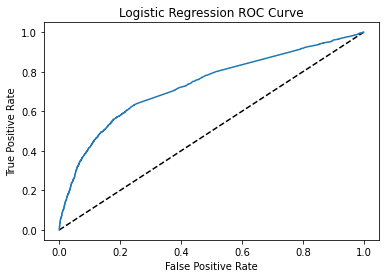

0.7328309668254334


In [ ]:
#Aftercappedtheoutliers

#train test split
x_train, x_test, y_train, y_test = train_test_split(x_no_outliers, y_no_outliers, test_size=0.2, random_state=12)


#standart scale and model fit
steps = [("scaler", StandardScaler()), 
         ("logreg", LogisticRegression())]
pipeline = Pipeline(steps)


pipeline.fit(x_train, y_train)
y_pred_probs = pipeline.predict_proba(x_test)[:,1]
y_pred = pipeline.predict(x_test)

print(y_pred, y_pred_probs)
print("AUC: {}".format(pipeline.score(x_test, y_test)))
print(classification_report(y_test, y_pred))

#Roc_auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot([0, 1], [0, 1],'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()
print(roc_auc_score(y_test, y_pred_probs))

Finding: AUC score decrease after eliminating outliers.

Hyperparameter Tuning
I continue the without capped because the auc of the model decrease.*

In [ ]:
#rebuild df_train_final_6
df_train_final6 = pd.concat([df_train_final5_isordered_0_sample, df_train_final5_isordered_1], axis = 0)
# defining the dependent and independent variables

x=df_train_final6[["quantity_L1_3D_user_group",
"quantity_L3_7D_user_group",
"quantity_L7_14D_user_group",
"productdetailcount_L1D_user_group",
"productdetailcount_L1_3D_user_group",
"productdetailcount_L3_7D_user_group",
"productdetailcount_L7_14D_user_group",
"fav_count_L1_3D_user_group",
"fav_count_L3_7D_user_group",
"fav_count_L7_14D_user_group",
"addtobasket_count_L3_7D_user_group",
"order_L7_14D_user",
"Bayan"]].values
y=df_train_final6["is_ordered"].values.reshape(-1,1)


#train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12)


#lOGREG with gridsearch
steps = [("scaler", StandardScaler()), 
         ("logreg", LogisticRegression())]
pipeline = Pipeline(steps)
params = {"logreg__solver": ["newton-cg", "saga", "lbfgs"],
         "logreg__C": np.linspace(0.001, 2 , 10)}
tuning = GridSearchCV(pipeline, param_grid = params)
tuning.fit(x_train, y_train)
y_pred_probs = tuning.predict_proba(x_test)[:,1]
y_pred = tuning.predict(x_test)
print(y_pred)

print("Tuned Logistic Regression Parameters: {}, AUC: {}".format(tuning.best_params_, roc_auc_score(y_test, y_pred_probs)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[0. 0. 0. ... 0. 1. 0.]
Tuned Logistic Regression Parameters: {'logreg__C': 2.0, 'logreg__solver': 'saga'}, AUC: 0.7343890233196341


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


After hyperparameter optimization, AUC: 0.7343890233196341 - a bit increase

**I am using the Tree-based feature selection module to build Tree Based Models**

In [ ]:
#rebuild df_train_final_6
df_train_final6 = pd.concat([df_train_final5_isordered_0_sample, df_train_final5_isordered_1], axis = 0)

# defining the dependent and independent variables

x_tree=df_train_final6[['quantity_L1D_user_group',
       'revenue_L1D_user_group', 'order_L1D_user_group', 'quantity_L1D_user',
       'revenue_L1D_user', 'order_L1D_user', 'quantity_L1_3D_user_group',
       'revenue_L1_3D_user_group', 'order_L1_3D_user_group',
       'quantity_L3_7D_user_group', 'revenue_L3_7D_user_group',
       'order_L3_7D_user_group', 'quantity_L7_14D_user_group',
       'revenue_L7_14D_user_group', 'order_L7_14D_user_group',
       'quantity_LOD_user_group', 'revenue_LOD_user_group',
       'order_LOD_user_group', 'productdetailcount_L1D_user_group',
       'productdetailcount_L1_3D_user_group',
       'productdetailcount_L3_7D_user_group',
       'productdetailcount_L7_14D_user_group', 'fav_count_L1D_user_group',
       'fav_count_L1_3D_user_group', 'fav_count_L3_7D_user_group',
       'fav_count_L7_14D_user_group', 'addtobasket_count_L1D_user_group',
       'addtobasket_count_L1_3D_user_group',
       'addtobasket_count_L3_7D_user_group',
       'addtobasket_count_L7_14D_user_group', 'quantity_L1_3D_user',
       'revenue_L1_3D_user', 'order_L1_3D_user', 'quantity_L3_7D_user',
       'revenue_L3_7D_user', 'order_L3_7D_user', 'quantity_L7_14D_user',
       'revenue_L7_14D_user', 'order_L7_14D_user', 'quantity_LOD_user',
       'revenue_LOD_user', 'order_LOD_user', 'productdetailcount_L1D_user',
       'productdetailcount_L1_3D_user', 'productdetailcount_L3_7D_user',
       'productdetailcount_L7_14D_user', 'fav_count_L1D_user',
       'fav_count_L1_3D_user', 'fav_count_L3_7D_user', 'fav_count_L7_14D_user',
       'addtobasket_count_L1D_user', 'addtobasket_count_L1_3D_user',
       'addtobasket_count_L3_7D_user', 'addtobasket_count_L7_14D_user',
       'search_count_L1D_user', 'search_count_L1_3D_user',
       'search_count_L3_7D_user', 'search_count_L7_14D_user', 'Bayan']]

y_tree=df_train_final6["is_ordered"]

#Tree-based feature selection

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(x_tree, y_tree)

model = SelectFromModel(clf, prefit=True)
x_new_tree = model.transform(x_tree)
print(x_new_tree[0])
feature_names_tree = x_tree.keys()
feature_importance_tree = pd.DataFrame(feature_names_tree, columns=["feature"])
feature_importance_tree["importance_tree"] = clf.feature_importances_
feature_importance_tree.sort_values(by="importance_tree", ascending=False)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0. 29.  0.  0.  0.  0.  0.  1.  0.]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,feature,importance_tree
21,productdetailcount_L7_14D_user_group,0.084841
20,productdetailcount_L3_7D_user_group,0.073926
18,productdetailcount_L1D_user_group,0.068895
45,productdetailcount_L7_14D_user,0.065491
19,productdetailcount_L1_3D_user_group,0.061677
44,productdetailcount_L3_7D_user,0.055046
43,productdetailcount_L1_3D_user,0.047521
57,search_count_L7_14D_user,0.044421
42,productdetailcount_L1D_user,0.039087
56,search_count_L3_7D_user,0.036480


I selected 17 features with high Importance and used them in the model.

In [ ]:
#Build a Desicion Tree Classifier
#rebuild df_train_final_6
df_train_final6 = pd.concat([df_train_final5_isordered_0_sample, df_train_final5_isordered_1], axis = 0)
#create x and y
x=df_train_final6[["productdetailcount_L7_14D_user_group",
"productdetailcount_L3_7D_user_group",
"productdetailcount_L1D_user_group",
"productdetailcount_L1_3D_user_group",
"productdetailcount_L7_14D_user",
"productdetailcount_L3_7D_user",
"productdetailcount_L1_3D_user",
"search_count_L7_14D_user",
"productdetailcount_L1D_user",
"search_count_L3_7D_user",
"search_count_L1_3D_user",
"revenue_L7_14D_user",
"search_count_L1D_user",
"fav_count_L7_14D_user",
"quantity_L7_14D_user",
"order_L7_14D_user",
"fav_count_L3_7D_user"]].values
y=df_train_final6["is_ordered"].values.reshape(-1,1)


#train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12)


#Scaling
steps = [("scaler", StandardScaler()), 
         ("DTC", DecisionTreeClassifier())]
pipeline = Pipeline(steps)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
y_pred_probs =pipeline.predict_proba(x_test)[:,1]
roc_auc_score(y_test, y_pred_probs)


0.6053916054343245

AUC score is lower than logistic regression. I will optimize hyper parameter and try again.

In [ ]:
#Desicion Tree with gridsearch
dt_model = DecisionTreeClassifier(random_state=12)
params = {"criterion": ["gini", "entropy", "log_loss"],
         "max_depth": np.linspace(2, 20, 10)}
tuning = GridSearchCV(dt_model, param_grid = params)
tuning.fit(x_train, y_train)
y_pred_probs = tuning.predict_proba(x_test)[:,1]
y_pred = tuning.predict(x_test)
print(y_pred)

print("Tuned Desicion Tree Parameters: {}, AUC: {}".format(tuning.best_params_, roc_auc_score(y_test, y_pred_probs)))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_mes

[0. 0. 1. ... 0. 0. 1.]
Tuned Desicion Tree Parameters: {'criterion': 'entropy', 'max_depth': 8.0}, AUC: 0.7516434429006023


**Finding: I increased the auc score from 0.606 to 0.744 by optimizing the hyperparameter.**

ADA Boost Classifier

In [ ]:
# Instantiate a classification-tree 'dt_ada'
dt_ada = DecisionTreeClassifier(max_depth=6, random_state=12)
# Instantiate an AdaBoost classifier 'adab_clf'
adb_clf = AdaBoostClassifier(base_estimator=dt_ada, n_estimators=100)
# Fit 'adb_clf' to the training set
adb_clf.fit(x_train, y_train)
# Predict the test set probabilities of positive class
y_pred_proba = adb_clf.predict_proba(x_test)[:,1]
# Evaluate test-set roc_auc_score
adb_clf_roc_auc_score = roc_auc_score(y_test, y_pred_proba)

# Print adb_clf_roc_auc_score
print('ROC AUC score: {:.2f}'.format(adb_clf_roc_auc_score))



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score: 0.69


Finding:Ada boost auc score is lower than desicion tree final result.

Gradiant Boosting

In [ ]:
# Instantiate a Gradiant Boosting
gdb_clf = GradientBoostingClassifier(n_estimators=300, max_depth=6)
# Fit 'gdb_clf' to the training set
gdb_clf.fit(x_train, y_train)
# Predict the test set probabilities of positive class
y_pred_proba = gdb_clf.predict_proba(x_test)[:,1]
# Evaluate test-set roc_auc_score
gdb_clf_roc_auc_score = roc_auc_score(y_test, y_pred_proba)

# Print adb_clf_roc_auc_score
print('ROC AUC score: {:.2f}'.format(gdb_clf_roc_auc_score))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score: 0.76


Stochastic Gradient Boosting in sklearn

In [ ]:
sgbt = GradientBoostingClassifier(max_depth=1,subsample=0.8,max_features=0.2,n_estimators=300,random_state=12)
# Fit 'sgbt' to the training set
sgbt.fit(x_train, y_train)
# Predict the test set labels
y_pred = sgbt.predict(x_test)
# Predict the test set probabilities of positive class
y_pred_proba = sgbt.predict_proba(x_test)[:,1]
# Evaluate test-set roc_auc_score
sgbt_clf_roc_auc_score = roc_auc_score(y_test, y_pred_proba)


# Print adb_clf_roc_auc_score
print('ROC AUC score: {:.2f}'.format(sgbt_clf_roc_auc_score))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score: 0.76


Findings: AUC Score
*   Stochastic gradient boosting is better than ada and gradient boosting


XGBOOST Classifier

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score: 0.77


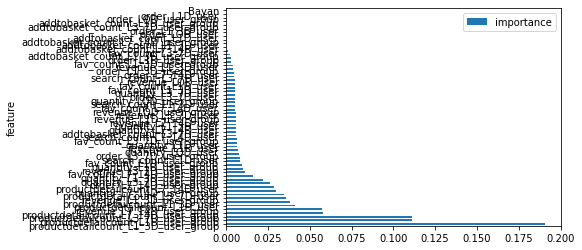

                                 feature  importance
19   productdetailcount_L1_3D_user_group    0.190607
18     productdetailcount_L1D_user_group    0.111361
20   productdetailcount_L3_7D_user_group    0.111121
21  productdetailcount_L7_14D_user_group    0.057881
13             revenue_L7_14D_user_group    0.057453
42           productdetailcount_L1D_user    0.041370
43         productdetailcount_L1_3D_user    0.038419
7               revenue_L1_3D_user_group    0.035843
44         productdetailcount_L3_7D_user    0.034808
12            quantity_L7_14D_user_group    0.029827
45        productdetailcount_L7_14D_user    0.028756
14               order_L7_14D_user_group    0.026334
9              quantity_L3_7D_user_group    0.021966
6              quantity_L1_3D_user_group    0.016256
25           fav_count_L7_14D_user_group    0.011094
10              revenue_L3_7D_user_group    0.010413
0                quantity_L1D_user_group    0.009748
22              fav_count_L1D_user_group    0.

In [ ]:
#rebuild df_train_final_6
df_train_final6 = pd.concat([df_train_final5_isordered_0_sample, df_train_final5_isordered_1], axis = 0)

# defining the dependent and independent variables

feature_names= df_train_final6[['quantity_L1D_user_group',
       'revenue_L1D_user_group', 'order_L1D_user_group', 'quantity_L1D_user',
       'revenue_L1D_user', 'order_L1D_user', 'quantity_L1_3D_user_group',
       'revenue_L1_3D_user_group', 'order_L1_3D_user_group',
       'quantity_L3_7D_user_group', 'revenue_L3_7D_user_group',
       'order_L3_7D_user_group', 'quantity_L7_14D_user_group',
       'revenue_L7_14D_user_group', 'order_L7_14D_user_group',
       'quantity_LOD_user_group', 'revenue_LOD_user_group',
       'order_LOD_user_group', 'productdetailcount_L1D_user_group',
       'productdetailcount_L1_3D_user_group',
       'productdetailcount_L3_7D_user_group',
       'productdetailcount_L7_14D_user_group', 'fav_count_L1D_user_group',
       'fav_count_L1_3D_user_group', 'fav_count_L3_7D_user_group',
       'fav_count_L7_14D_user_group', 'addtobasket_count_L1D_user_group',
       'addtobasket_count_L1_3D_user_group',
       'addtobasket_count_L3_7D_user_group',
       'addtobasket_count_L7_14D_user_group', 'quantity_L1_3D_user',
       'revenue_L1_3D_user', 'order_L1_3D_user', 'quantity_L3_7D_user',
       'revenue_L3_7D_user', 'order_L3_7D_user', 'quantity_L7_14D_user',
       'revenue_L7_14D_user', 'order_L7_14D_user', 'quantity_LOD_user',
       'revenue_LOD_user', 'order_LOD_user', 'productdetailcount_L1D_user',
       'productdetailcount_L1_3D_user', 'productdetailcount_L3_7D_user',
       'productdetailcount_L7_14D_user', 'fav_count_L1D_user',
       'fav_count_L1_3D_user', 'fav_count_L3_7D_user', 'fav_count_L7_14D_user',
       'addtobasket_count_L1D_user', 'addtobasket_count_L1_3D_user',
       'addtobasket_count_L3_7D_user', 'addtobasket_count_L7_14D_user',
       'search_count_L1D_user', 'search_count_L1_3D_user',
       'search_count_L3_7D_user', 'search_count_L7_14D_user', 'Bayan']].keys()
x_XGB=df_train_final6[['quantity_L1D_user_group',
       'revenue_L1D_user_group', 'order_L1D_user_group', 'quantity_L1D_user',
       'revenue_L1D_user', 'order_L1D_user', 'quantity_L1_3D_user_group',
       'revenue_L1_3D_user_group', 'order_L1_3D_user_group',
       'quantity_L3_7D_user_group', 'revenue_L3_7D_user_group',
       'order_L3_7D_user_group', 'quantity_L7_14D_user_group',
       'revenue_L7_14D_user_group', 'order_L7_14D_user_group',
       'quantity_LOD_user_group', 'revenue_LOD_user_group',
       'order_LOD_user_group', 'productdetailcount_L1D_user_group',
       'productdetailcount_L1_3D_user_group',
       'productdetailcount_L3_7D_user_group',
       'productdetailcount_L7_14D_user_group', 'fav_count_L1D_user_group',
       'fav_count_L1_3D_user_group', 'fav_count_L3_7D_user_group',
       'fav_count_L7_14D_user_group', 'addtobasket_count_L1D_user_group',
       'addtobasket_count_L1_3D_user_group',
       'addtobasket_count_L3_7D_user_group',
       'addtobasket_count_L7_14D_user_group', 'quantity_L1_3D_user',
       'revenue_L1_3D_user', 'order_L1_3D_user', 'quantity_L3_7D_user',
       'revenue_L3_7D_user', 'order_L3_7D_user', 'quantity_L7_14D_user',
       'revenue_L7_14D_user', 'order_L7_14D_user', 'quantity_LOD_user',
       'revenue_LOD_user', 'order_LOD_user', 'productdetailcount_L1D_user',
       'productdetailcount_L1_3D_user', 'productdetailcount_L3_7D_user',
       'productdetailcount_L7_14D_user', 'fav_count_L1D_user',
       'fav_count_L1_3D_user', 'fav_count_L3_7D_user', 'fav_count_L7_14D_user',
       'addtobasket_count_L1D_user', 'addtobasket_count_L1_3D_user',
       'addtobasket_count_L3_7D_user', 'addtobasket_count_L7_14D_user',
       'search_count_L1D_user', 'search_count_L1_3D_user',
       'search_count_L3_7D_user', 'search_count_L7_14D_user', 'Bayan']].values
y_XGB=df_train_final6["is_ordered"].values.reshape(-1,1)

#train test split
x_train, x_test, y_train, y_test = train_test_split(x_XGB, y_XGB, test_size=0.2, random_state=12)
              

XGB = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
XGB.fit(x_train, y_train)
y_pred = XGB.predict(x_test)
y_pred_proba = XGB.predict_proba(x_test)[:,1]
XGB_clf_roc_auc_score = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC score: {:.2f}'.format(XGB_clf_roc_auc_score))

# plot

feature_importance = pd.DataFrame(feature_names, columns=["feature"])
feature_importance["importance"] = XGB.feature_importances_
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
 

ax = feature_importance.plot.barh(x='feature', y='importance')

plt.show()
print(feature_importance)




Based on Feature Importance table, I select 45 feature above zero.
i just select "fav_count_L1_3D_user_group" despite being 0 importance to not want to split time interval

In [ ]:
#XGBOOST After Feature Selection

#rebuild df_train_final_6
df_train_final6 = pd.concat([df_train_final5_isordered_0_sample, df_train_final5_isordered_1], axis = 0)

# defining the dependent and independent variables

x_XGB=df_train_final6[['productdetailcount_L1_3D_user_group',
'productdetailcount_L3_7D_user_group',
'productdetailcount_L1D_user_group',
'revenue_L7_14D_user_group',
'productdetailcount_L7_14D_user_group',
'productdetailcount_L1D_user',
'productdetailcount_L3_7D_user',
'quantity_L7_14D_user_group',
'productdetailcount_L1_3D_user',
'productdetailcount_L7_14D_user',
'revenue_L1_3D_user_group',
'quantity_L3_7D_user_group',
'order_LOD_user_group',
'quantity_L1_3D_user_group',
'order_L3_7D_user_group',
'revenue_LOD_user',
'revenue_L1D_user_group',
'search_count_L3_7D_user',
'fav_count_L7_14D_user_group',
'quantity_LOD_user_group',
'revenue_L3_7D_user_group',
'search_count_L7_14D_user',
'revenue_L3_7D_user',
'quantity_L1_3D_user',
'revenue_L1D_user',
'search_count_L1D_user',
'fav_count_L1_3D_user',
'fav_count_L7_14D_user',
'quantity_L7_14D_user',
'fav_count_L1D_user_group',
'quantity_L1D_user_group',
'quantity_LOD_user',
'fav_count_L1D_user',
'revenue_L1_3D_user',
'order_L1D_user',
'search_count_L1_3D_user',
'revenue_L7_14D_user',
'quantity_L3_7D_user',
'revenue_LOD_user_group',
'fav_count_L3_7D_user_group',
'addtobasket_count_L1_3D_user',
'order_LOD_user',
'fav_count_L3_7D_user',
'order_L1_3D_user',
'fav_count_L1_3D_user_group']].values

y_XGB=df_train_final6["is_ordered"].values.reshape(-1,1)

#train test split
x_train, x_test, y_train, y_test = train_test_split(x_XGB, y_XGB, test_size=0.2, random_state=12)
              

XGB = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
XGB.fit(x_train, y_train)
y_pred = XGB.predict(x_test)
y_pred_proba = XGB.predict_proba(x_test)[:,1]
XGB_clf_roc_auc_score = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC score: {:.2f}'.format(XGB_clf_roc_auc_score))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score: 0.77


Finding: I reduced the model's feature count without reducing the model's auc score

# **Final I Choose XGBClassifier**

Prepare test data

In [ ]:
df_test_final = df_test.merge(trx_L1D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("test", "")) \
.merge(trx_L1D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1D_user_group", "_L1D_user")) \
.merge(trx_L1_3D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("", "_L1_3D_user_group")) \
.merge(trx_L3_7D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L1_3D_user_group", "_L3_7D_user_group")) \
.merge(trx_L7_14D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L3_7D_user_group", "")) \
.merge(trx_L0D_gby_userid_bu, on= ["userid","currentbugroupname"], how="left", suffixes = ("_L7_14D_user_group", "_LOD_user_group")) \
.merge(visit_L1D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L0D_user_group", "_L1D_user_group")) \
.merge(visit_L1_3D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L1D_user_group", "_L1_3D_user_group")) \
.merge(visit_L3_7D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L1_3D_user_group", "_L3_7D_user_group")) \
.merge(visit_L7_14D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L3_7D_user_group", "_L7_14D_user_group")) \
.merge(fav_L1D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L7_14D_user_group", "_L1D_user_group")) \
.merge(fav_L1_3D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L1D_user_group", "_L1_3D_user_group")) \
.merge(fav_L3_7D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L1_3D_user_group", "_L3_7D_user_group")) \
.merge(fav_L7_14D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L3_7D_user_group", "_L7_14D_user_group")) \
.merge(basket_L1D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L7_14Dv", "_L1D_user_group")) \
.merge(basket_L1_3D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L1D_user_group", "_L1_3D_user_group")) \
.merge(basket_L3_7D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L1_3D_user_group", "_L3_7D_user_group")) \
.merge(basket_L7_14D_gby_userid_bu, on = ["userid","currentbugroupname"], how="left", suffixes = ("_L3_7D_user_group", "_L7_14D_user_group")) \
.merge(trx_L1_3D_gby_userid, on = ["userid"], how="left", suffixes = ("_L7_14D_user_group", "_L1_3D_user")) \
.merge(trx_L3_7D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1_3D_user", "_L3_7D_user")) \
.merge(trx_L7_14D_gby_userid, on = ["userid"], how="left", suffixes = ("_L3_7D_user", "")) \
.merge(trx_L0D_gby_userid, on= ["userid"], how="left", suffixes = ("_L7_14D_user", "_LOD_user")) \
.merge(visit_L1D_gby_userid, on = ["userid"], how="left", suffixes = ("_L0D_user", "_L1D_user")) \
.merge(visit_L1_3D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1D_user", "_L1_3D_user")) \
.merge(visit_L3_7D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1_3D_user", "_L3_7D_user")) \
.merge(visit_L7_14D_gby_userid, on = ["userid"], how="left", suffixes = ("_L3_7D_user", "_L7_14D_user")) \
.merge(fav_L1D_gby_userid, on = ["userid"], how="left", suffixes = ("_L7_14D_user", "_L1D_user")) \
.merge(fav_L1_3D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1D_user", "_L1_3D_user")) \
.merge(fav_L3_7D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1_3D_user", "_L3_7D_user")) \
.merge(fav_L7_14D_gby_userid, on = ["userid"], how="left", suffixes = ("_L3_7D_user", "_L7_14D_user")) \
.merge(basket_L1D_gby_userid, on = ["userid"], how="left", suffixes = ("_L7_14D_user", "_L1D_user")) \
.merge(basket_L1_3D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1D_user", "_L1_3D_user")) \
.merge(basket_L3_7D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1_3D_user", "_L3_7D_user")) \
.merge(basket_L7_14D_gby_userid, on = ["userid"], how="left", suffixes = ("_L3_7D_user", "_L7_14D_user")) \
.merge(search_L1D_gby_userid, on = ["userid"], how="left", suffixes = ("_L7_14D_user", "_L1D_user")) \
.merge(search_L1_3D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1D_user", "_L1_3D_user")) \
.merge(search_L3_7D_gby_userid, on = ["userid"], how="left", suffixes = ("_L1_3D_user", "_L3_7D_user")) \
.merge(search_L7_14D_gby_userid, on = ["userid"], how="left", suffixes = ("_L3_7D_user", "_L7_14D_user")) \
.merge(df_demo, on="userid", how= "left")

df_test_final.columns

Index(['userid', 'currentbugroupname', 'probability', 'target',
       'quantity_L1D_user_group', 'revenue_L1D_user_group',
       'order_L1D_user_group', 'quantity_L1D_user', 'revenue_L1D_user',
       'order_L1D_user', 'quantity_L1_3D_user_group',
       'revenue_L1_3D_user_group', 'order_L1_3D_user_group',
       'quantity_L3_7D_user_group', 'revenue_L3_7D_user_group',
       'order_L3_7D_user_group', 'quantity_L7_14D_user_group',
       'revenue_L7_14D_user_group', 'order_L7_14D_user_group',
       'quantity_LOD_user_group', 'revenue_LOD_user_group',
       'order_LOD_user_group', 'productdetailcount_L1D_user_group',
       'productdetailcount_L1_3D_user_group',
       'productdetailcount_L3_7D_user_group',
       'productdetailcount_L7_14D_user_group', 'fav_count_L1D_user_group',
       'fav_count_L1_3D_user_group', 'fav_count_L3_7D_user_group',
       'fav_count_L7_14D_user_group', 'addtobasket_count_L1D_user_group',
       'addtobasket_count_L1_3D_user_group',
       'addtobaske

XGBOOST Model for prediction

In [ ]:
#rebuild df_train_final_6
df_train_final6 = pd.concat([df_train_final5_isordered_0_sample, df_train_final5_isordered_1], axis = 0)

# defining the dependent and independent variables

x_XGB_final=df_train_final6[['productdetailcount_L1_3D_user_group',
'productdetailcount_L3_7D_user_group',
'productdetailcount_L1D_user_group',
'revenue_L7_14D_user_group',
'productdetailcount_L7_14D_user_group',
'productdetailcount_L1D_user',
'productdetailcount_L3_7D_user',
'quantity_L7_14D_user_group',
'productdetailcount_L1_3D_user',
'productdetailcount_L7_14D_user',
'revenue_L1_3D_user_group',
'quantity_L3_7D_user_group',
'order_LOD_user_group',
'quantity_L1_3D_user_group',
'order_L3_7D_user_group',
'revenue_LOD_user',
'revenue_L1D_user_group',
'search_count_L3_7D_user',
'fav_count_L7_14D_user_group',
'quantity_LOD_user_group',
'revenue_L3_7D_user_group',
'search_count_L7_14D_user',
'revenue_L3_7D_user',
'quantity_L1_3D_user',
'revenue_L1D_user',
'search_count_L1D_user',
'fav_count_L1_3D_user',
'fav_count_L7_14D_user',
'quantity_L7_14D_user',
'fav_count_L1D_user_group',
'quantity_L1D_user_group',
'quantity_LOD_user',
'fav_count_L1D_user',
'revenue_L1_3D_user',
'order_L1D_user',
'search_count_L1_3D_user',
'revenue_L7_14D_user',
'quantity_L3_7D_user',
'revenue_LOD_user_group',
'fav_count_L3_7D_user_group',
'addtobasket_count_L1_3D_user',
'order_LOD_user',
'fav_count_L3_7D_user',
'order_L1_3D_user',
'fav_count_L1_3D_user_group']].values

y_XGB_final=df_train_final6["is_ordered"].values.reshape(-1,1)

x_XGB_test=df_test_final[['productdetailcount_L1_3D_user_group',
'productdetailcount_L3_7D_user_group',
'productdetailcount_L1D_user_group',
'revenue_L7_14D_user_group',
'productdetailcount_L7_14D_user_group',
'productdetailcount_L1D_user',
'productdetailcount_L3_7D_user',
'quantity_L7_14D_user_group',
'productdetailcount_L1_3D_user',
'productdetailcount_L7_14D_user',
'revenue_L1_3D_user_group',
'quantity_L3_7D_user_group',
'order_LOD_user_group',
'quantity_L1_3D_user_group',
'order_L3_7D_user_group',
'revenue_LOD_user',
'revenue_L1D_user_group',
'search_count_L3_7D_user',
'fav_count_L7_14D_user_group',
'quantity_LOD_user_group',
'revenue_L3_7D_user_group',
'search_count_L7_14D_user',
'revenue_L3_7D_user',
'quantity_L1_3D_user',
'revenue_L1D_user',
'search_count_L1D_user',
'fav_count_L1_3D_user',
'fav_count_L7_14D_user',
'quantity_L7_14D_user',
'fav_count_L1D_user_group',
'quantity_L1D_user_group',
'quantity_LOD_user',
'fav_count_L1D_user',
'revenue_L1_3D_user',
'order_L1D_user',
'search_count_L1_3D_user',
'revenue_L7_14D_user',
'quantity_L3_7D_user',
'revenue_LOD_user_group',
'fav_count_L3_7D_user_group',
'addtobasket_count_L1_3D_user',
'order_LOD_user',
'fav_count_L3_7D_user',
'order_L1_3D_user',
'fav_count_L1_3D_user_group']].fillna(0).values


XGB = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
XGB.fit(x_XGB_final, y_XGB_final)
y_pred = XGB.predict(x_XGB_test)
y_pred_proba = XGB.predict_proba(x_XGB_test)[:,1]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#final_solution
df_test.drop(["probability", "target"], axis=1)
df_test["probability"]= y_pred_proba
df_test["target"]= y_pred

df_test.head()
df_test.to_csv("df_test_final.csv")